In [1]:
import networkx as nx
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
from IPython.display import Image
from operator import mul
from functools import reduce
from tqdm import tqdm, trange

# Assignment APMLA-WS 2021-22: 

## Belief Propagation for random matching problem

 Matching is another classical problem of graph theory. It is related to a dimer problem in statistical physics. Given a  (unweighted,
  undirected) graph $G(V,E)$ a matching $M \subseteq E$ is defined as a subset of edges such that if $(ij) \in M$ then
    no other edge that contains node $i$ or $j$ can be in $M$. In other words a matching is a subset of edges such that no two edges of the
    set share a node. 

 Fill up this _jupyter_ notebook with the skeleton of a code to solve this assignment. 

### Point a)
Write a probability distribution that is uniform over all
    matchings on a given graph. _Hint_: consider binary random variables $\sigma_{ij}$ on the network edges.

### Point b)
Write a probability distribution that that gives a larger weight to larger matchings, where the
    size of a matching is simply $|M|$. _Hint_: you need to write $|M|$ as a function of $|E|$ and $\sum_{(ij)\in E}\sigma_{ij}$ for $\sigma_{ij}\in M$.

### Point c)
Draw a factor graph corresponding to it for the example of a graph with 6 nodes and edges $E=\left\{(1,2),(1,3),(2,3),(1,4),(2,5), (3,6)\right\}$. You can add it to the notebook as a figure or using latex package _tikz_.

In [2]:
#Image("./path.png")
# function_params = {}
function_params = {"color": "white", "edge": {"color": ""}}

functions = [
    "1", "2", "3", "4", "5", "6"
]
# variable_params = {}
variable_params = {"color": "black", "edge": {"color": ""}}
variables = ["(1,2)", "(1,3)", "(2,3)", "(1,4)", "(2,5)", "(3,6)"]
edges = [
    ("(1,2)", "1"),
    ("(1,2)", "2"),
    ("(1,3)", "1"),
    ("(1,3)", "3"),
    ("(2,3)", "2"),
    ("(2,3)", "3"),
    ("(1,4)", "1"),
    ("(1,4)", "4"),
    ("(2,5)", "2"),
    ("(2,5)", "5"),
    ("(3,6)", "3"),
    ("(3,6)", "6")
    ]

example_graph = nx.Graph()
example_graph.add_nodes_from([(var, variable_params) for var in variables])
example_graph.add_nodes_from([(var, function_params) for var in functions])
example_graph.add_edges_from(edges)



function_labels = {i: r"$\psi_" + i + "$" for i in functions}
variable_labels = {ij: r"$\sigma_{" + ij[1] + ij[3] + "}$" for ij in variables}
labels = function_labels
labels.update(variable_labels)

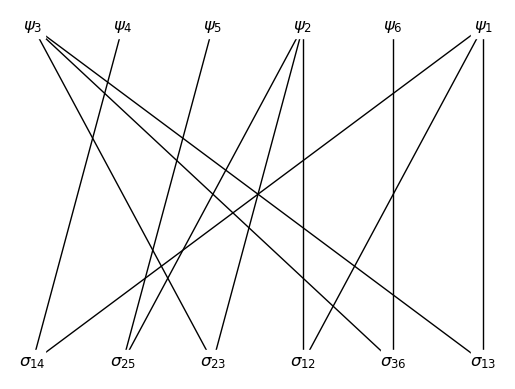

In [3]:
fig, axs = plt.subplots()
nx.draw(example_graph, ax=axs, node_shape="s", pos=nx.bipartite_layout(example_graph, functions, align="horizontal"), labels=labels, node_color="white")
plt.show()

# Upper represent function nodes (Nodes), lower variable nodes (edges)


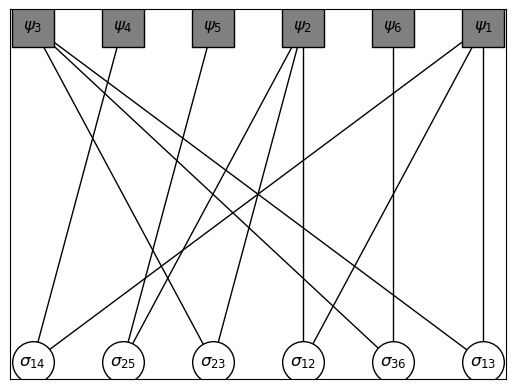

In [4]:
pos = nx.bipartite_layout(example_graph, functions, align="horizontal")

options = {"edgecolors": "black", "node_size": 900}
nx.draw_networkx_nodes(example_graph, pos, nodelist=variables, node_color="white", **options)
nx.draw_networkx_nodes(example_graph, pos, nodelist=functions, node_color="grey", node_shape="s", **options)
nx.draw_networkx_edges(example_graph, pos)


nx.draw_networkx_labels(example_graph, pos, labels)

plt.show()


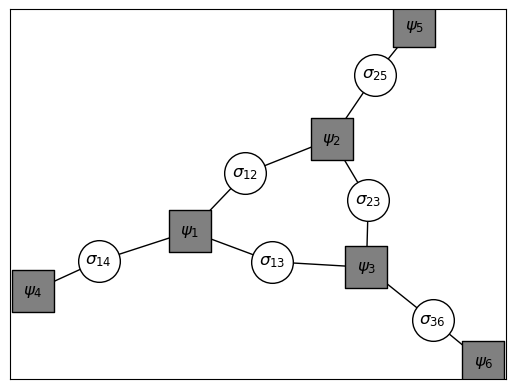

In [5]:
pos = nx.spring_layout(example_graph)

options = {"edgecolors": "black", "node_size": 900}
nx.draw_networkx_nodes(example_graph, pos, nodelist=variables, node_color="white", **options)
nx.draw_networkx_nodes(example_graph, pos, nodelist=functions, node_color="grey", node_shape="s", **options)
nx.draw_networkx_edges(example_graph, pos)
nx.draw_networkx_labels(example_graph, pos, labels)

plt.show()


### Point d)
Using BP to model marginals of the matching assignment, denote as:
 * $\nu_{\sigma_{ij}}^{(ij) \to i} $ the messages from _variable_ node $(ij)$ to _function_ node $i$.
 * $  \hat{\nu}_{\sigma_{ij}}^{i \to (ij)}$ the message from _function_ node $i$ to  _variable_ node $(ij)$.  
 
Note that they are both functions of the state $\sigma_{ij}$ of variable node $(ij)$.  
	_Hint_: here variable nodes (circles) correspond to an edge $e=(i,j) \in E$ and factor nodes (squares) correspond to nodes $i \in V$ in the \textit{original} network $G(V,E)$.  
* Write BP equations for this model.   
_Hint_: write an explicit derivation for _each of the two possible_ values of $\sigma_{ij}$.
	Notice that we are implementing _hard_ constraints. This means that for each value of $\sigma_{ij}$, there can be only a limited number of _allowed_ configurations of $\left\{\sigma_{ik}\right\}$, for $k \in \partial i \setminus j$. In principle there should be $\sim 2^{k_{i}-1}$ of them, but in practice, many are not allowed once $\sigma_{ij}$ is fixed; we remain with ${k_{i}}$ allowed configurations (for one of the two values of $\sigma_{ij}$) and only one configuration allowed for the other value of $\sigma_{ij}$. Do _not_ consider the configuration where $(ij) \notin M$ AND $(ik)  \notin M$, $\forall k \in \partial i \setminus j$, for a total of ${k_{i}}-1$ allowed configuration to be considered in the BP implementation.


### Point e)
Write the equation for the one-point marginal $P(\sigma_{i})$ and the two-point marginal $P(\sigma_{i},\sigma_{j})$ obtained from BP.

## BP Implementation (point f)

### Point i)
Implement the BP equations for Erdos-Renyi graphs of $N=200$ nodes as derived above. 

In [8]:
# Generate graph
N, c = 200, 4  # N is the number of nodes, c is the average degree
G = nx.erdos_renyi_graph(n=N, p=c/(N-1), seed=29)
# G = G.to_directed() # 

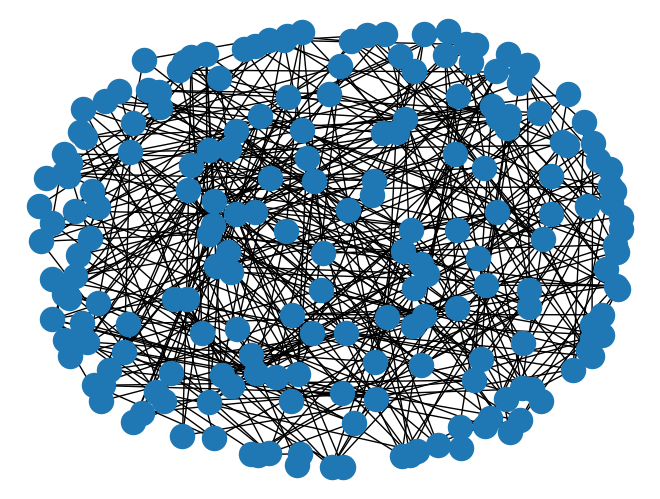

In [9]:
# inspect the graph
pos=nx.spring_layout(G,k=1)
nx.draw(G, pos)
plt.show()

# Solution Phillip

In [10]:
def compute_marginal(G, var_message):
    marginal=1
    for fac in var_message:
        marginal *= var_message[fac][0]
    return marginal

In [11]:
def plot_marginal_graph(edge_marginals, G):
    new_graph = nx.Graph()
    for node in G.nodes():
        new_graph.add_node(node)
    for edge, value in edge_marginals.items():
        if value==1:
            new_graph.add_edge(edge[0], edge[1])
    fig, axs = plt.subplots()
    nx.draw(new_graph, ax=axs, node_shape="s", with_labels=True)
    plt.show()

In [12]:
# Checking the convergence
def convergence(message_new, G, abs_tol):
    edge_marginals = {}
    # soft marginals
    for edge in G.edges():
        edge_marginals[edge] = compute_marginal(G, message_new[edge]) # if p(X=0) > 0.5, choose X=0 else X=1 (by round operation)

    _ = 0
    # hard marginals
    for edge in G.edges():
        edge_marginals[edge] = 1 - round(compute_marginal(G, message_new[edge])) # if p(X=0) > 0.5, choose X=0 else X=1 (by round operation)
    


    err = 0
    n_total_edges = len(G.edges)
    for node in G.nodes():
        node_edges = 0
        for edge in G.edges(node):
            try:
                node_edges += edge_marginals[edge]
            except:
                node_edges += edge_marginals[(edge[1], edge[0])]
        err += int(node_edges > 1)
    err /= n_total_edges
    if err < abs_tol:
        plot_marginal_graph(edge_marginals, G)
    return(err, err < abs_tol)

In [13]:
def compute_fac_to_var_message(G, fac, var):
    # for computation, we assume variable/egde is 0
    message_sum = 0
    neighbour_edges = G.edges(fac)
    neighbour_edges = list(G.edges(fac))
    neighbour_edges.remove(var)
    for active_edge in neighbour_edges: # we just need to iterate over all possible neighbours since just one of them can be one at a time
        zero_edges = neighbour_edges.copy()
        zero_edges.remove(active_edge)
        product = [G.edges()[edge]['message_t'][fac][1] for edge in zero_edges] # get the incoming message to fac for all neighbours beeing 0
        active_prob = (1 - G[active_edge[0]][active_edge[1]]["message_t"][fac][1])
        message_sum += reduce(mul, product, 1)* active_prob # multiply be incoming for neighbour beeing 1 and add to sum

    return message_sum

def compute_var_to_fac_message(G, fac, var):
    other = var[0] if var[0]!=fac else var[1]
    return G.edges()[var]['message_t'][other][0] # incoming message from other factor


In [14]:

def BP(G, init='random', update='parallel', max_it=1000, abs_tol=1e-4, alpha=0.1, report=False, seed=98):
    if init == 'random':
        np.random.seed(seed)
        for e in G.edges():
            # for each edge we have two messages, one in each direction
            # for both directions we have bernoulli so we could pass the probability distribution as [p(x=0), p(x=1)]
            p = np.random.rand(4)
            # we have order by connection to factor node and the incoming and outgoing message
            # incoming message at pos 0
            G.edges()[e]['message_t'] = {e[0]: [p[0], p[1]], e[1]: [p[2], p[3]]}# FILL just randomly init each message
    elif init == 'all-negative':
        p_value = 0.8
        for e in G.edges():
            G.edges()[e]['message_t'] = {e[0]: [p_value, p_value], e[1]: [p_value, p_value]}# dummy FILL init all mesages as believen sigma_ij is 0 
    elif init == 'all-positive':
        p_value = 0.1
        for e in G.edges():
            G.edges()[e]['message_t'] = {e[0]: [p_value, p_value], e[1]: [p_value, p_value]}# dummy FILL init all messages as believing sigma_ij is 1 
        


    # Iterating
    conv, it = False, 0# FILL
    differences = []

    pbar = trange(1000)
    if update=='parallel':
        while not conv and (it < 1000): # FILL
            # print("iteration", it)
            # for e in G.edges():
            #     print(e, G.edges()[e]['message_t'])
            message_new = {}
            for e in G.edges():
                i = e[0]
                j = e[1]
                new_message_t = {i:[None, None], j: [None, None]}
                # first update incoming messages
                new_message_t[i][0] = compute_fac_to_var_message(G, i, (i,j))
                new_message_t[j][0] = compute_fac_to_var_message(G, j, (j,i))
                # then update outgoing messages
                new_message_t[i][1] = compute_var_to_fac_message(G, i, (i,j))
                new_message_t[j][1] = compute_var_to_fac_message(G, j, (j,i))
                message_new[e] = new_message_t
                # FILL
                # here update both messages as in the equations, however dont save directly since we only should update after timestep   
                # FILL
                    
            diff, conv = convergence(message_new, G, abs_tol)
            pbar.set_description(f"It {it}, error:{diff}")
            differences.append(diff)
            it+=1
            # FILL
            # now update the whole edges
            for e in G.edges():
                G.edges()[e]['message_t'] = message_new[e]

    elif update=='random':
        while not conv and (it < 1000):# FILL:
            # print("iteration", it)
            # for e in G.edges():
            #     print(e, G.edges()[e]['message_t'])
            message_old = {}
            perm = list(G.edges())
            np.random.seed(seed)
            np.random.shuffle(perm)
            for e in perm:
                # message_old[e] = -1# FILL why do we need to fill this??
                i = e[0]
                j = e[1]
                new_message_t = {i:[None, None], j: [None, None]}
                # first update incoming messages
                new_message_t[i][0] = compute_fac_to_var_message(G, i, (i,j))
                new_message_t[j][0] = compute_fac_to_var_message(G, j, (j,i))
                # then update outgoing messages
                new_message_t[i][1] = compute_var_to_fac_message(G, i, (i,j))
                new_message_t[j][1] = compute_var_to_fac_message(G, j, (j,i))
                # here we directly update instead of first computing all updates and then looking at them
                G.edges()[e]['message_t'] = new_message_t
                message_old[e] = new_message_t

            diff, conv = convergence(message_old, G, abs_tol)
            pbar.set_description(f"It {it}, error:{diff}")
            differences.append(diff)
            it+=1
            seed+=1
    
    if report:
        print('Number of iterations: {0}'.format(it))
    
    return(it, differences)

In [15]:
# BP(G, update="random", init="random")

# Solution David

In [35]:
# Generate graph
N, c = 200, 4  # N is the number of nodes, c is the average degree
# G = nx.erdos_renyi_graph(n=N, p=c/(N-1), seed=29)
G = nx.erdos_renyi_graph(n=N, p=10/(N-1), seed=29)
# G = G.to_directed() # 

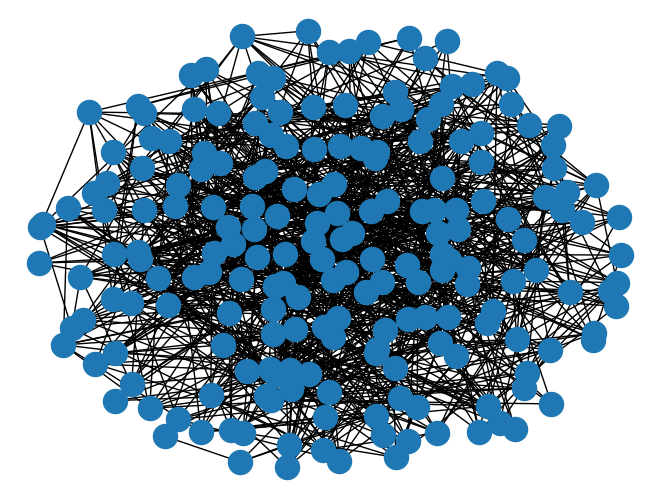

In [36]:
# inspect the graph
pos=nx.spring_layout(G,k=1)
nx.draw(G, pos)
plt.show()

In [37]:
def plot_marginal_graph(edge_marginals, G):
    new_graph = nx.Graph()
    for node in G.nodes():
        new_graph.add_node(node)
    for edge, value in edge_marginals.items():
        if value==1:
            new_graph.add_edge(edge[0], edge[1])
    fig, axs = plt.subplots()
    pos=nx.spring_layout(new_graph,k=1)
    nx.draw(new_graph, ax=axs, pos=pos, node_shape="s", with_labels=True)
    plt.show()

In [38]:
def compute_marginal(G, e):
    m1 = G.nodes()[e[0]]["message_t"][e]
    m2 = G.nodes()[e[1]]["message_t"][e]
    marginal = m1 * m2

    #normalize
    marginal = marginal / marginal.sum()
    return marginal

In [39]:
# Checking the convergence

# TODO wait for tutorial 10 for definition of how to get the error?
# TODO remove message_new or do something useful with it
# TODO don't do this with message_new but use a copy of the graph
def convergence(message_new, G, abs_tol, overwrite_plot = False):

    # We could check the convergence from the messages in message_new or from the messages in G

    #lets just use G for now
    edge_marginals = {}
    # soft marginals
    for edge in G.edges():
        edge_marginals[edge] = compute_marginal(G, edge) # if p(X=0) > 0.5, choose X=0 else X=1 (by round operation)



    # Maximal Likely solution
    edges_ml = {}
    for e in edge_marginals:
        edges_ml[e] = int(edge_marginals[e][1] > 0.5)


    err = 0
    for node in G.nodes():

        # This would be nice, but the edges from G.edges(node) do not necessarily have the same order as before
        # err += sum([edges_ml[e] for e in G.edges(node)]) > 1
        edgesum = 0
        for e in G.edges(node):
            if e in edges_ml:
                edgesum += edges_ml[e]
            else:
                edgesum += edges_ml[(e[1], e[0])]
        err += edgesum > 1


    err /= len(G.edges())

    if err < abs_tol or overwrite_plot:
        plot_marginal_graph(edges_ml, G)


    # FILL
    return(err, err < abs_tol)


In [40]:
# Some comments for understanding

# factors i have k_i messages (one to all (ik) for which k is a neighbour of i)

# variables (ij) have two messages (one to i and one to j)

# messages are a function in \sigma_{ij} where \sigma_{ij} can take values \in {0,1}
# we therefore represent messages as np.array([a, b])
# I realize we would not have needed to do this with tuples, since the second value follows from the first


# we store the messages in the "message_t" field which is a dictionary containing as keys all the targets
# e.g.:
# G.nodes(5)["message_t"][(5,8)] == np.array([0.2, 0.8])
# G.nodes(5)["message_t"][(5,20)] == np.array([0.3, 0.7])
# G.nodes(5)["message_t"][(5,25)] == np.array([0.7, 0.3])

# or:
# G.edges((5,8))["message_t"][5] == np.array([0.6, 0.4])
# G.edges((5,8))["message_t"][8] == np.array([0.5, 0.5])

# So the message \nu_{\sigma_{5,8}}^{(5,8) \rightarrow 5} == np.array([0.6, 0.4])




In [41]:
def compute_var_to_fac_message(G, var, fac):
    # We would do
    # get all neighbors of var except fac
    # take product of all their messages

    # But the only neighbour of var except of fac is the other node

    other = var[0] if var[0]!=fac else var[1]

    # in the first iteration the factors do not have the "message_t" yet
    try:
        ret = G.nodes()[other]['message_t'][var]
    except:
        # TODO We should pass messages here consistent with the initialization
        # We just do random for now
        p = np.random.rand()
        ret = np.array([p, 1-p])
    return ret # incoming message from other factor



def compute_fac_to_var_message(G, fac, var):
    
    # Get neighbouring edges except for var
    neighbour_edges = list(G.edges(fac))


    # var in neighbour_edges can be permuted
    if var in neighbour_edges:
        neighbour_edges.remove(var)
    else:
        neighbour_edges.remove((var[1], var[0]))


    # get the product of incoming messages
    # Then take the sum over all values of that the \sigmas which are the neighbours of i could assume

    

    # get all values that the neighbours could assume:
    # since we know that the factor would be zero if there were more than one with value 1 we can exclude most combinations
    
    # This implementation does not look like BP in the traditional sense where we explicitly write the factor
    # We can use the factor implicitly, since we know that only one or less than one of the values can be zero.



    product_function = [G.edges()[e]['message_t'][fac] for e in neighbour_edges]

    # negative == edge does not exist
    negatives = [v[0] for v in product_function]
    positives = [v[1] for v in product_function]

    product_of_negatives = reduce(mul, negatives, 1)
    # for the sum, let any one of the edges be one (the calculation is somewhat convoluted):

    # we find the sum for when sigma (the variable) is 0
    negative_sum = 0
    for i in range(len(neighbour_edges)):
        negative_sum += reduce(mul, negatives[:i] + [positives[i]] + negatives[i+1:], 1)


    # TODO old remove    
    # for i in range(len(neighbour_edges)):
    #     if negatives[i] == 0:
    #         prod = 0
    #     else:
    #         prod = product_of_negatives / negatives[i] * positives[i]
    #     negative_sum += prod


    # add the all negative case
    # negative_sum += product_of_negatives
    # We do not allow this!


    # we find the sum for when sigma (the variable) is 1
    # This allows only one case for the factor to be nonzero which is if all other adjecent edges 
    positive_sum = product_of_negatives


    # TODO test without this
    # Small addition for numerical stability
    message = np.array([negative_sum + 1e-23, positive_sum + 1e-23])
    # message = np.array([negative_sum, positive_sum])

    # normalization
    message = message / message.sum()


    return message

    # for ne in neighbour_edges:


    #     factor = ... <= 1
    #     productmessage = (1,1)

    #     # The following is wrong!
    #     for p in product:
    #         productmessage[0] *= p[0]
    #         productmessage[1] *= p[1]

        
    #     message_sum += factor * reduce(mul, product, 1)


    # message_sum = 0
    # for active_edge in neighbour_edges: # we just need to iterate over all possible neighbours since just one of them can be one at a time
    #     zero_edges = neighbour_edges.copy()
    #     zero_edges.remove(active_edge)
    #     product = [G.edges()[edge]['message_t'][fac][1] for edge in zero_edges] # get the incoming message to fac for all neighbours beeing 0
    #     active_prob = (1 - G[active_edge[0]][active_edge[1]]["message_t"][fac][1])
    #     message_sum += reduce(mul, product, 1)* active_prob # multiply be incoming for neighbour beeing 1 and add to sum

    # return message_sum



In [42]:
def BP(G, init='random', update='random', max_it=1000, abs_tol=1e-4, alpha=0.1, report=False, seed=98):
    
    # TODO copy the graph

    if init == 'random':
        np.random.seed(seed)
        for e in G.edges():
            G.edges()[e]['message_t'] = {} # FILL
            
            p = np.random.rand()
            G.edges()[e]['message_t'][e[0]] = np.array([p, 1-p]) 

            p = np.random.rand()
            G.edges()[e]['message_t'][e[1]] = np.array([p, 1-p])

         # TODO initialize the factor messages   
    
    elif init == 'all-negative':
        for e in G.edges():
            # We can not initialize the values fully to 0/1 due to numerical instabilities
            G.edges()[e]['message_t'] = {} # FILL
            G.edges()[e]['message_t'][e[0]] = np.array([0.99, 0.01]) 
            G.edges()[e]['message_t'][e[1]] = np.array([0.99, 0.01])


    elif init == 'all-positive':
        for e in G.edges():
            G.edges()[e]['message_t'] = {} # FILL
            G.edges()[e]['message_t'][e[0]] = np.array([0.01, 0.99]) 
            G.edges()[e]['message_t'][e[1]] = np.array([0.01, 0.99])
        
    # Iterating
    conv, it = False, 0 # FILL
    differences = []
    

    if update=='parallel':
        progress_bar = tqdm(range(max_it))
        for _ in progress_bar:
            if conv:
                break
            messages_new_variables = {}
            messages_new_factors = {}
            for e in G.edges():
                i = e[0]
                j = e[1]

                # We want to do the following, but in parallel, therefore we need to keep this information somewhere
                # G.nodes()[i]['message_t'][e] = compute_fac_to_var_message(G, i, e)
                # G.nodes()[j]['message_t'][e] = compute_fac_to_var_message(G, j, e)

                # G.edges()[e]['message_t'][i] = compute_var_to_fac_message(G, e, i)
                # G.edges()[e]['message_t'][j] = compute_var_to_fac_message(G, e, j)

                if not i in messages_new_factors:
                    messages_new_factors[i] = {}
                messages_new_factors[i][e] = compute_fac_to_var_message(G, i, e)
                
                if not j in messages_new_factors:
                    messages_new_factors[j] = {}
                messages_new_factors[j][e] = compute_fac_to_var_message(G, j, e)

                messages_new_variables[e] = {}
                messages_new_variables[e][i] = compute_var_to_fac_message(G, e, i)
                messages_new_variables[e][j] = compute_var_to_fac_message(G, e, j)

                
                
                # FILL
                        
                # FILL

                # TODO there could be a collapsed version where we don't need the factors (see L7 fromula (5)) but i'm not sure
                # message_new[e] = ...
                    

            # FILL
            # now update the whole edges
            for e in G.edges():
                G.edges()[e]['message_t'] = messages_new_variables[e]
            for n in messages_new_factors:
                # For nodes that are not connected it is possible that they were never thouched in the code above
                # and therefore have no message in message_new, which could result in an error
                G.nodes()[n]['message_t'] = messages_new_factors[n]


            diff, conv = convergence(messages_new_variables, G, abs_tol)
            progress_bar.set_description(f"It {it}, error:{diff}")
            differences.append(diff)
            it+=1


    elif update=='random':
        progress_bar = tqdm(range(max_it))
        for _ in progress_bar:
            if conv:
                break
            message_old = {}
            perm = list(G.edges())
            np.random.seed(seed)
            np.random.shuffle(perm)
            for e in perm:
                message_old[e] = {}# FILL
                i = e[0]
                j = e[1]
                
                if not "message_t" in G.nodes()[i]:
                    G.nodes()[i]["message_t"] = {}
                G.nodes()[i]['message_t'][e] = compute_fac_to_var_message(G, i, e)

                if not "message_t" in G.nodes()[j]:
                    G.nodes()[j]["message_t"] = {}
                G.nodes()[j]['message_t'][e] = compute_fac_to_var_message(G, j, e)

                G.edges()[e]['message_t'][i] = compute_var_to_fac_message(G, e, i)
                G.edges()[e]['message_t'][j] = compute_var_to_fac_message(G, e, j)



            diff, conv = convergence(message_old, G, abs_tol)
            progress_bar.set_description(f"It {it}, error:{diff}")
            differences.append(diff)
            it+=1
            seed+=1
    
    if report:
        print('Number of iterations: {0}'.format(it))
        
    # convergence(None, G, abs_tol, overwrite_plot=True)

    return(it, differences)

  0%|          | 0/500 [00:00<?, ?it/s]

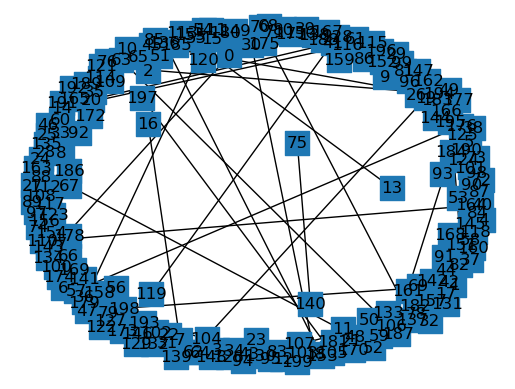

It 0, error:0.0:   0%|          | 1/500 [00:01<11:14,  1.35s/it]


(1, [0.0])

In [44]:
BP(G, init='all-positive', update='random', report=False, max_it=500)

## Point ii) 
Check how the behavior depends on the order of update for the ``random'' initialization, i.e. compare what happens if you update all messages at once or sequentially at random one by one.

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

# Parallel update (all messages at once)
x, y = BP(# FILL)
ax[0].plot(np.arange(x), y)
ax[0].set_title('Parallel update', size=16)
ax[0].set_xlabel('Number of iterations',size=12)
ax[0].set_ylabel('$err$',size=12)

# Random update (one by one)
x, y = BP(# FILL)
ax[1].plot(np.arange(x), y)
ax[1].set_title('Random update', size=16)
ax[1].set_xlabel('Number of iterations', size=12)
ax[1].set_ylabel('$err$',size=12)

plt.show()

SyntaxError: invalid syntax (<ipython-input-52-3c883bd1d63f>, line 6)

As last time, the parallel update needs more iterations for reaching the converge than the random update. 

### Point iii)
  Initialize BP in 3 different ways (recall that they are a function of random variables $\sigma_{ij} \in \left\{0,1\right\}$): 
* ``random'' : each of the two possible values of $\sigma_{ij}$ is selected uniformly at random in $(0,1)$;
*  ``all-negative'' : close to the point $(1,0)$;
* ``all-positive'' : close to the point $(0,1)$;  

and iterate the equations until convergence for each of these three.   
Define converge as the time when the $err< \tilde{\epsilon}$ (as defined in tutorial 10).  
* Plot the behavior of  $err$ as a function of iteration time for the 3 different initializations (one plot with 3 curves).  

Use the update (parallel or sequential at random) that converges faster.


In [ ]:
N, c = 200, 4

G = nx.erdos_renyi_graph(n=N, p=c/(N-1), seed=29)
G = G.to_directed()

plt.figure(figsize=(10,5))
for # FILL:
    print('\nInitialization {0}'.format(# FILL))
    x, y = BP(# FILL)
    plt.plot(np.arange(x), y, label=# FILL)
plt.legend(fontsize=12)
plt.xlabel('Number of iterations',size=12)
plt.ylabel('$err$', size=12)
plt.show()

### Point iv)
For parameters where the update converges, plot the convergence time as a function of the average degree $c=[2,\dots,7]$.  
Do this on as large graphs as is  feasible with your code.

In [ ]:
c_choices = np.linspace(2, 7, 12)
N_choices = [# FILL]
result = np.zeros((len(c_choices),len(N_choices)+1))
result[:, 0] = c_choices
seed_graph = 29
for j, N in enumerate(N_choices):
    print(N)
    for i, c in enumerate(c_choices):
        iterations = []
        for _ in range(5):
            G = nx.erdos_renyi_graph(n=N, p=c/(N-1), seed=seed_graph)
            G = G.to_directed()        
            x, y = BP(# FILL)
            iterations.append(x)
            seed_graph+=1
        result[i, j+1] = np.median(iterations)

In [ ]:
plt.figure(figsize=(10,5))
for col in range(len(N_choices)):
    plt.plot(result[:,0], result[:,col+1], label='N = {0}'.format(N_choices[col]))
plt.legend(fontsize=12)
plt.xlabel('Average degree $c$', size=12)
plt.ylabel('Converge iteration', size=12)
plt.show()

### Point v)
Assign one color value $\in \left\{0,1\right\}$, $1$ if the edge belong to the matching, 0 otherwise, to each edge at convergence, based on the argmax of the suitable marginals.  

In [ ]:
# Attaching marginal distributions to each edge
def marginals_one_point(G):
    for e in G.edges():
        i = e[0]
        j = e[1]

        G.edges()[(i,j)]['marginal'] = # FILL
        
# Assessing the matching
def accuracy(G):
    # error is when a violation occurs 
    # FILL
    return(errors)

def calculate_edge_in_matching(G):
    '''
    Fraction of edges in M
    '''
    # FILL

Compute the fraction of violations of the matching requirement you get over $N_{real}=10$ initializations of the graph and plot them as a function of $c$.


In [ ]:
c_choices = np.linspace(2, 7, 6)
result1 = np.zeros((len(c_choices),4))
result1[:, 0] = c_choices
N = 100
seed = 29
N_real=10
for i, c in enumerate(c_choices):
    errors = []
    n_one = 0
    for _ in range(N_real):
        G = nx.erdos_renyi_graph(n=N, p=c/(N-1), seed=seed)
        G = G.to_directed()
        x, y = BP(# FILL)
        marginals_one_point(# FILL)
        errors.append(# FILL)  
        M_size= calculate_edge_in_matching(G)
        n_one+=M_size
        seed+=1
        print(c,errors[-1],M_size)
    print()
    result1[i, 1] = np.mean(errors)
    result1[i, 2] = np.std(errors)
    result1[i, 3] = n_one/float(N_real)  # save the mean of the fraction of +1 
    print('Total:',c,result1[i, 1],result1[i, 3])
    print()
    print()

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(result1[:,0], result1[:,1])
plt.xlabel('Average degree $c$', size=12)
plt.ylabel('Fraction of violations', size=12)
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(result1[:,0], result1[:,3])
plt.xlabel('Average degree $c$', size=12)
plt.ylabel('Fraction of edges in the set $M$', size=12)
plt.show()

### Additional examples

In [ ]:
def draw_graph(G, init):
    plt.figure(figsize=(10,5))
    # nodes
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, nodelist=list(np.arange(N)), node_size=500, node_color='lightblue')
    # some math labels
    labels = {}
    for n in range(N):
        labels[n] = n
    nx.draw_networkx_labels(G, pos, labels, font_size=12)

    # edges
    col_positive = []
    col_negative = []
    for e in G.edges():
        if np.argmax(G.edges()[e]['marginal'])==1:
            col_positive.append(e)
        else:
            col_negative.append(e)

    nx.draw_networkx_edges(G, pos, edgelist=col_negative, width=1, edge_color='b')
    nx.draw_networkx_edges(G, pos, edgelist=col_positive,width=2, edge_color='r')
    
    plt.title('Initialization: {0}'.format(init), size=15)
    plt.show()

In [ ]:
N, c = 28, 3
G = nx.erdos_renyi_graph(n=N, p=c/(N-1), seed=486)
G = G.to_directed()
for # FILL
    x, y = BP(# FILL)
    marginals_one_point(G)
    print('Number of errors: ', accuracy(# FILL))
    draw_graph(G, # FILL)

### Point vi)
Plot also the fraction of edges in the set $M$ as a function of $c$ and for the 3 different initializations on the same plot. 

In [ ]:
# Generate graph
N, c = 100, 3  # N is the number of nodes, c is the average degree
G = nx.erdos_renyi_graph(n=N, p=c/(N-1), seed=29)
G = G.to_directed()

N_real=10

In [ ]:
initializations=# FILL
degrees=[2,3,4,5,6,7]

M={};errors={}
for init in initializations:
    errors[init]={}
    M[init]={}
    for c in degrees:
        errors[init][c]=np.zeros(N_real)
        M[init][c]=np.zeros(N_real)

for c in degrees:
    for r in range(N_real):
        G = nx.erdos_renyi_graph(n=N, p=c/(N-1),seed=r)
        G = G.to_directed()
        for # FILL
            x, y = BP(# FILL)
            marginals_one_point(G)
            errors[init][c][r]=accuracy(# FILL)/N  # the maximum number of errors is given by the number of nodes
            M[init][c][r]=calculate_edge_in_matching(# FILL)

In [ ]:
colors={'random':'b','all-negative':'r','all-positive':'g'}
plt.figure()

t=0
for c in degrees:
    i=t
    for init in initializations:
        if t==0:
            plt.scatter(i,M[init][c].mean(),label=init,c=colors[init])
        else:
            plt.scatter(i,M[init][c].mean(),c=colors[init])
        plt.errorbar(i,M[init][c].mean(), yerr=M[init][c].std(),c=colors[init])
        i+=0.1
    t+=1

plt.legend(loc='best')
plt.ylabel('|M|')
plt.xlabel('c')
# plt.xticks([])

### Point vii) 
Comment on how the behavior depends on the initialization.